In [1]:
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython import display
import random
import scipy.stats
from sklearn import metrics
from sklearn.metrics import roc_curve
import os

In [2]:
def get_data(args, valid_experiment_list):
    indices = np.empty((args['total_data_examples'], len(valid_experiment_list)))

    # model=beit_base_patch16_224.in22k_ft_in22k_in1k_mode=nonDP_type=ixg_nsamples=20

    for i, exp in enumerate(valid_experiment_list):
        if 'nonDP' not in args['clipping_mode']:
            lira_dir = f"lira/indices_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_eps={args['epsilon']}_epochs={args['epochs']}"
        else:
            lira_dir = f"lira/indices_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_epochs={args['epochs']}"
        df = pd.read_csv(f"{lira_dir}/{exp}.csv")
        indices[:,i] = df[str(exp)][:args['total_data_examples']]
    indices = indices.astype(bool)

    scores = np.empty((args['total_data_examples'], args['num_experiments']))

    for i, exp in enumerate(valid_experiment_list):
        if 'nonDP' not in args['clipping_mode']:
            lira_dir = f"lira/{args['attack_type']}_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_eps={args['epsilon']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
        else:
            lira_dir = f"lira/{args['attack_type']}_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
        df = pd.read_csv(f"{lira_dir}/{exp}.csv")
        scores[:,i] = df[str(exp)][:args['total_data_examples']]
    return indices, scores

In [3]:
# def get_data(args):
#     indices = np.empty((args['total_data_examples'], args['num_experiments']))

#     # model=beit_base_patch16_224.in22k_ft_in22k_in1k_mode=nonDP_type=ixg_nsamples=20

#     for i in range(args['num_experiments']):
#         if 'nonDP' not in args['clipping_mode']:
#             lira_dir = f"lira/indices_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_eps={args['epsilon']}_epochs={args['epochs']}"
#         else:
#             lira_dir = f"lira/indices_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_epochs={args['epochs']}"
#         df = pd.read_csv(f"{lira_dir}/{i}.csv")
#         indices[:,i] = df[str(i)][:args['total_data_examples']]
#     indices = indices.astype(bool)

#     scores = np.empty((args['total_data_examples'], args['num_experiments']))

#     for i in range(args['num_experiments']):
#         if 'nonDP' not in args['clipping_mode']:
#             lira_dir = f"lira/variances_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_eps={args['epsilon']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
#         else:
#             lira_dir = f"lira/variances_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
#         df = pd.read_csv(f"{lira_dir}/{i}.csv")
#         scores[:,i] = df[str(i)][:args['total_data_examples']]
#     return indices, scores

In [4]:
# indices = np.empty((args['total_data_examples'], args['num_experiments']))

# # model=beit_base_patch16_224.in22k_ft_in22k_in1k_mode=nonDP_type=ixg_nsamples=20

# for i in tqdm(range(args['num_experiments'])):
#     if 'nonDP' not in args['clipping_mode']:
#         lira_dir = f"lira/indices_{args['cifar_data']}/model={args['model']}_mode={args['clipping_mode']}_eps={args['epsilon']}_epochs={args['epochs']}"
#     else:
#         lira_dir = f"lira/indices_{args['cifar_data']}/model={args['model']}_mode={args['clipping_mode']}_epochs={args['epochs']}"
#     df = pd.read_csv(f"{lira_dir}/{i}.csv")
#     indices[:,i] = df[str(i)]
# indices = indices.astype(bool)
    
# scores = np.empty((args['total_data_examples'], args['num_experiments']))

# for i in tqdm(range(args['num_experiments'])):
#     if 'nonDP' not in args['clipping_mode']:
#         lira_dir = f"lira/variances_{args['cifar_data']}/model={args['model']}_mode={args['clipping_mode']}_eps={args['epsilon']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
#     else:
#         lira_dir = f"lira/variances_{args['cifar_data']}/model={args['model']}_mode={args['clipping_mode']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
#     df = pd.read_csv(f"{lira_dir}/{i}.csv")
#     scores[:,i] = df[str(i)]

In [5]:
def calculate_mean(scores, indices):
    non_zero_mask = (indices != 0)
    # Calculate the sum of each row, considering only non-zero values
    row_sums = np.sum(scores * non_zero_mask, axis=1)

    # Calculate the count of non-zero values in each row
    non_zero_count = np.sum(non_zero_mask, axis=1)

    # Calculate the mean of each row, considering only non-zero values
    row_means = row_sums / non_zero_count
    return row_means

In [6]:
def calculate_std(scores, indices):
    # Calculate the mean of each row, considering only non-zero values
    non_zero_mask = (indices != 0)
    row_means = np.sum(scores * non_zero_mask, axis=1) / np.sum(non_zero_mask, axis=1)

    # Subtract the mean from each element in the corresponding row
    centered_matrix = scores - row_means[:, np.newaxis]

    # Square the result obtained in the previous step
    squared_differences = centered_matrix ** 2

    # Calculate the mean of the squared differences for each row, considering only non-zero values
    mean_squared_differences = np.sum(squared_differences * non_zero_mask, axis=1) / np.sum(non_zero_mask, axis=1)

    # Take the square root of the result obtained in the previous step
    std_deviation = np.sqrt(mean_squared_differences)
    return std_deviation

In [7]:
def split_scores(scores, ind_mask_all, min_keep=3, attack_model_index=0):
    #            scores  indices                    # idx_t0
    n_keep = min_keep - 1
    # overwrite this
    n_keep = n_keep - 1
    M = ind_mask_all.shape[1]
    # t0 data with arbitrary (idx to be attacked)
    mask_t0 =  ind_mask_all[:, attack_model_index]
    t0 = scores[:, attack_model_index]
    # remaining data
    other_inds = np.delete(range(M), attack_model_index).tolist()
    ind_mask_all = ind_mask_all[:,other_inds]
    scores = scores[:, other_inds]
    # compute ins and outs
    maskin = ind_mask_all * 1
    maskout = (1-ind_mask_all) * 1
    scores_in = scores * maskin
    scores_out = scores * maskout
    # make sure to have at least min_keep
    nzi = np.zeros(scores_in.shape[0], dtype=bool)
    non_zeros_in = np.where(np.sum(maskin, axis=1) > n_keep)[0]
    nzi[non_zeros_in] = True
    nzo = np.zeros(scores_out.shape[0], dtype=bool)
    non_zeros_out = np.where(np.sum(maskout, axis=1) > n_keep)[0]
    nzo[non_zeros_out] = True
    ind_keep = np.where(((nzi*1)*(nzo*1))!=0)[0]
    # update everything
    scores_in = scores_in[ind_keep]   # update scores in
    scores_out = scores_out[ind_keep] # update scores out
    t0 = t0[ind_keep]                 # update t0
    mask_t0 = mask_t0[ind_keep]       # update mask
    # compute averages
    normalizer_in = np.count_nonzero(scores_in, axis=1)
    normalizer_out = np.count_nonzero(scores_out, axis=1)
    in_scores = np.sum(scores_in, axis=1)/normalizer_in # m_scores_unlearned
    out_scores = np.sum(scores_out, axis=1)/normalizer_out # m_scores_retained
    return in_scores, out_scores, t0, mask_t0

In [8]:
def get_lrt_scores(owner_scores, owner_indices, in_scores, out_scores, global_var):
    #                t0             mask_t0  m_scores_unlearn_lrt   m_scores_holdout_lrt
    # compute lrt scores
    in_means = np.mean(in_scores) # mean_scores_unlearn_lrt
    out_means = np.mean(out_scores)  # mean_scores_holdout_lrt
    in_stds = np.std(in_means) # std_unlearn
    out_stds = np.std(out_means) # std_holdout
    if global_var:
        overall_std = np.std(np.array([in_scores, out_scores]))
        in_stds = overall_std
        out_stds = overall_std
    pr_in_lrt = -scipy.stats.norm.logpdf(owner_scores, in_scores, in_stds+1e-15)
    pr_out_lrt = -scipy.stats.norm.logpdf(owner_scores, out_scores, out_stds+1e-15)
    scores_lrt = pr_in_lrt - pr_out_lrt
#     print(np.shape(scores_lrt))
    in_scores = scores_lrt[owner_indices]
#     print(owner_indices)
#     print(np.shape(in_scores))
    out_scores = scores_lrt[~owner_indices]
#     print(np.shape(out_scores))
    return in_scores, out_scores

In [9]:
def sweep(score, x):
    """
    Compute a ROC curve and then return the FPR, TPR, AUC, and ACC.
    Args:
        Score: the likelihood ratios
        x: the true membership of each example in the owner model
    """
    fpr, tpr, _ = roc_curve(x, -score, pos_label=1)
    acc = np.max(1-(fpr+(1-tpr))/2)
    return fpr, tpr, metrics.auc(fpr, tpr), acc

In [10]:
def compute_curve(in_scores: np.array, out_scores: np.array, pos_label=1):
#     print(np.shape(in_scores))
#     print(np.shape(out_scores))
    y = np.r_[np.ones(np.shape(in_scores)[0]), np.zeros(np.shape(out_scores)[0])]
#     y = np.concatenate([np.ones(in_scores.shape[0]), np.zeros(out_scores.shape[0])])
    fs, ts, thresholds = roc_curve(y, np.r_[in_scores, out_scores], pos_label=pos_label)
    acc = np.max(1-(fs+(1-ts))/2)
    return ts, fs, metrics.auc(ts, fs), acc

In [11]:
def do_plot(nrows, ncols, subplot_index, fpr, tpr, auc, acc, legend='', metric='auc', sweep_fn=sweep):
    """
    Generate the ROC curves by using ntest models as test models and the rest to train.
    """
    
    low = tpr[np.where(fpr<=.001)[0][-1]]
    low2 = tpr[np.where(fpr<=.01)[0][-1]]

    print('Attack %s AUC %.4f, Accuracy %.4f, TPR@0.1%%FPR of %.4f'%(legend, auc,acc, low))
    print('TPR@1%%FPR of %.4f'%(low2))

    metric_text = ''
    if metric == 'auc':
        metric_text = 'auc=%.3f'%auc
    elif metric == 'acc':
        metric_text = 'acc=%.3f'%acc

#     plt.subplot(nrows, ncols, subplot_index)
    fig = plt.figure(figsize=(7,3)) 
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=legend+metric_text)
    plt.semilogx()
    plt.semilogy()
    plt.xlim(0.001,1)
    plt.ylim(0.001,1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot([0, 1], [0, 1], ls='--', color='gray')
    plt.subplots_adjust(bottom=.18, left=.18, top=.96, right=.96)
    plt.legend(fontsize=8)
    
    plt.subplot(1,2,2)
    plt.plot(fpr, tpr, label=legend+metric_text)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot([0, 1], [0, 1], ls='--', color='gray')
    plt.subplots_adjust(bottom=.18, left=.18, top=.96, right=.96)
    
    return (acc,auc)

In [12]:
epsilons = [0.5, 1.0, 2.0, 8.0]
mean_fpr = np.linspace(0, 1, 10000)
epochs_list = [10, 30]
global_exp_type = 'ixg'
global_num_experiments = 17
global_savefig = True
global_attacktype = 'L1 Norm'
global_attacktype_dir = 'norms_l1'

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


0it [00:00, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


0it [00:00, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


0it [00:00, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


0it [00:00, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


0it [00:00, ?it/s]

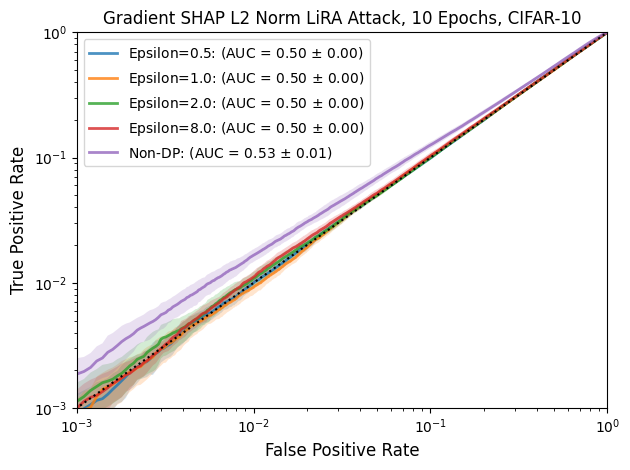

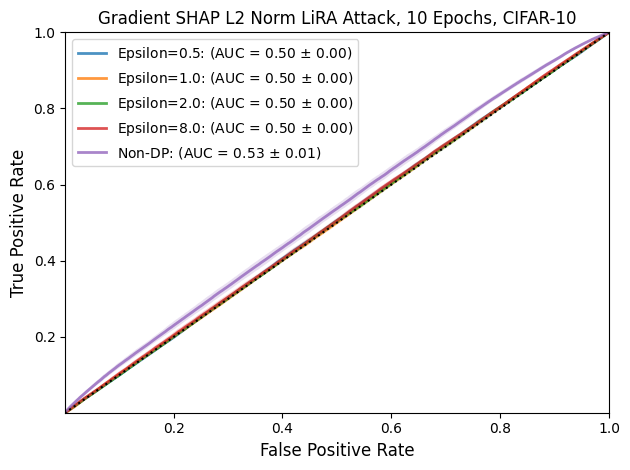

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


0it [00:00, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


0it [00:00, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


0it [00:00, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


0it [00:00, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


0it [00:00, ?it/s]

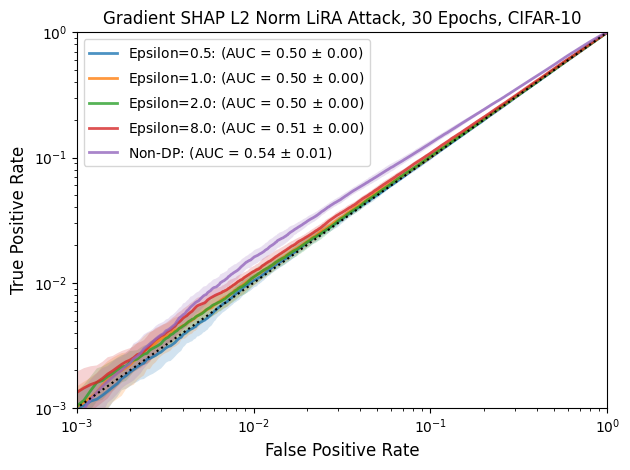

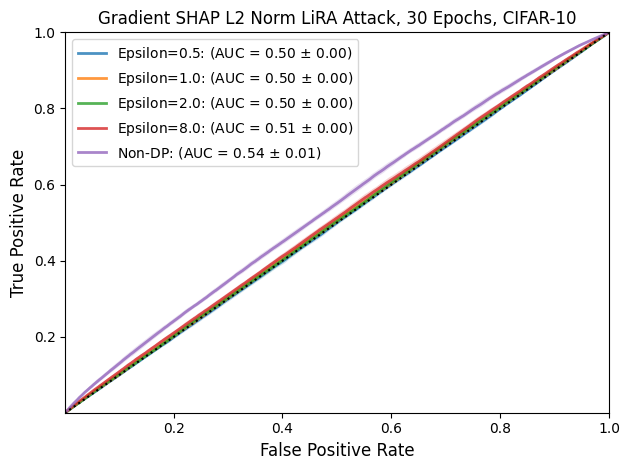

In [31]:
for epochs in epochs_list:
    
    results = {
    'BK-MixOpt': {'0.5': {'tprs': [], 'aucs': []},
                   '1.0': {'tprs': [], 'aucs': []},
                   '2.0': {'tprs': [], 'aucs': []},
                  '5.0': {'tprs': [], 'aucs': []},
                   '8.0': {'tprs': [], 'aucs': []}},
    'nonDP':  {'tprs': [], 'aucs': []},
    }

    args = {
        'clipping_mode': 'BK-MixOpt',
        'cifar_data': 'CIFAR10',
        'model': 'vit_small_patch16_224', # 'vit_small_patch16_224', 
        'total_data_examples': 20000,
        'num_experiments': global_num_experiments,
        'explanation_type': global_exp_type,
        'nsamples': 20,
        'epochs': epochs,
        'attack_type': global_attacktype_dir
    }

    for eps in epsilons:
        tpr_001_dir = f'lira/tpr001_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
        tpr_01_dir = f'lira/tpr01_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
        auc_dir = f'lira/auc_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
        if not os.path.exists(tpr_001_dir):
            os.makedirs(tpr_001_dir)
            print(f"Created directory: {tpr_001_dir}")
        if not os.path.exists(tpr_01_dir):
            os.makedirs(tpr_01_dir)
            print(f"Created directory: {tpr_01_dir}")
        if not os.path.exists(auc_dir):
            os.makedirs(auc_dir)
            print(f"Created directory: {auc_dir}")
        tpr_001_file_path = f'{tpr_001_dir}/model={args["model"]}_mode={args["clipping_mode"]}_eps={eps}_type={args["explanation_type"]}_epochs={args["epochs"]}.txt'
        tpr_01_file_path = f'{tpr_01_dir}/model={args["model"]}_mode={args["clipping_mode"]}_eps={eps}_type={args["explanation_type"]}_epochs={args["epochs"]}.txt'
        auc_file_path = f'{auc_dir}/model={args["model"]}_mode={args["clipping_mode"]}_eps={eps}_type={args["explanation_type"]}_epochs={args["epochs"]}.txt'
        with open(tpr_001_file_path, 'w') as file:
            pass
        with open(tpr_01_file_path, 'w') as file:
            pass
        with open(auc_file_path, 'w') as file:
            pass

    for i, eps in enumerate(epsilons):
        args['epsilon'] = eps
        
        valid_experiment_list = []
        for attack_model_index in range(args['num_experiments']):
            if 'nonDP' not in args['clipping_mode']:
                lira_dir = f"lira/{args['attack_type']}_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_eps={args['epsilon']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
            else:
                lira_dir = f"lira/{args['attack_type']}_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
            if os.path.exists(f"{lira_dir}/{attack_model_index}.csv"):
                valid_experiment_list.append(attack_model_index)
        print(valid_experiment_list)
        
        for attack_model_index, _ in tqdm(enumerate(valid_experiment_list)): # can eventually iterate only 10 times

            tpr_001_dir = f'lira/tpr001_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
            tpr_01_dir = f'lira/tpr01_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
            auc_dir = f'lira/auc_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
            
            tpr_001_file_path = f'{tpr_001_dir}/model={args["model"]}_mode={args["clipping_mode"]}_eps={eps}_type={args["explanation_type"]}_epochs={args["epochs"]}.txt'
            tpr_01_file_path = f'{tpr_01_dir}/model={args["model"]}_mode={args["clipping_mode"]}_eps={eps}_type={args["explanation_type"]}_epochs={args["epochs"]}.txt'
            auc_file_path = f'{auc_dir}/model={args["model"]}_mode={args["clipping_mode"]}_eps={eps}_type={args["explanation_type"]}_epochs={args["epochs"]}.txt'
            
            indices, scores = get_data(args, valid_experiment_list)

            in_scores, out_scores, t0, mask_t0 = split_scores(scores, indices, min_keep=3, attack_model_index=attack_model_index)
#             plt.figure(figsize=(4,4))
#             plt.hist(np.log(in_scores), alpha=0.7, bins=np.linspace(-18, -6, 13))
#             plt.hist(np.log(out_scores), alpha=0.7, bins=np.linspace(-18, -6, 13))
            in_scores, out_scores = get_lrt_scores(t0, mask_t0, in_scores, out_scores, global_var=True)

            num_rows = int(np.ceil(args['num_experiments'] / 4))
            num_cols = 4

            fpr, tpr, auc, acc = compute_curve(in_scores, out_scores)
            tpr = np.interp(mean_fpr, fpr, tpr)
            tpr[0] = 0.0
            low_001 = tpr[np.where(fpr<=.001)[0][-1]]
            low_01 = tpr[np.where(fpr<=.01)[0][-1]]

            with open(tpr_001_file_path, 'a') as file:
                file.write(str(low_001) + '\n')
            with open(tpr_01_file_path, 'a') as file:
                file.write(str(low_01) + '\n')
            with open(auc_file_path, 'a') as file:
                file.write(str(auc) + '\n')

            results['BK-MixOpt'][str(eps)]['tprs'].append(tpr)
            results['BK-MixOpt'][str(eps)]['aucs'].append(auc)   

    args = {
        'clipping_mode': 'nonDP',
        'cifar_data': 'CIFAR10',
        'model': 'vit_small_patch16_224', # 'vit_small_patch16_224', 
        'total_data_examples': 20000,
        'num_experiments': global_num_experiments,
        'explanation_type': global_exp_type,
        'nsamples': 20,
        'epochs': epochs,
        'attack_type': global_attacktype_dir
    }

    valid_experiment_list = []
    for attack_model_index in range(args['num_experiments']):
        if 'nonDP' not in args['clipping_mode']:
            lira_dir = f"lira/{args['attack_type']}_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_eps={args['epsilon']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
        else:
            lira_dir = f"lira/{args['attack_type']}_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
        if os.path.exists(f"{lira_dir}/{attack_model_index}.csv"):
            valid_experiment_list.append(attack_model_index)
    print(valid_experiment_list)
    
    for attack_model_index, _ in tqdm(enumerate(valid_experiment_list)): # can eventually iterate only 10 times
        args['epsilon'] = eps
        
        indices, scores = get_data(args, valid_experiment_list)

        in_scores, out_scores, t0, mask_t0 = split_scores(scores, indices, min_keep=3, attack_model_index=attack_model_index)
    #     plt.figure(figsize=(4,4))
    #     plt.hist(np.log(in_scores), alpha=0.7, bins=np.linspace(-18, -6, 13))
    #     plt.hist(np.log(out_scores), alpha=0.7, bins=np.linspace(-18, -6, 13))
    #     plt.title('non DP')
        in_scores, out_scores = get_lrt_scores(t0, mask_t0, in_scores, out_scores, global_var=True)

        num_rows = int(np.ceil(args['num_experiments'] / 4))
        num_cols = 4

        fpr, tpr, auc, acc = compute_curve(in_scores, out_scores)
        tpr = np.interp(mean_fpr, fpr, tpr)
        tpr[0] = 0.0
        low_001 = tpr[np.where(fpr<=.001)[0][-1]]
        low_01 = tpr[np.where(fpr<=.01)[0][-1]]
        results['nonDP']['tprs'].append(tpr)
        results['nonDP']['aucs'].append(auc)

    ##### PLOTTING CODE STARTS HERE #####

    plt.figure()
    for i, eps in enumerate(epsilons):
        tprs = np.array(results['BK-MixOpt'][f'{eps}']['tprs']).T
        aucs = np.array(results['BK-MixOpt'][f'{eps}']['aucs']).T
        mean_tpr = np.mean(tprs, axis=1)
        std_tpr = np.std(tprs, axis=1)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs).round(2)
        std_auc = np.std(aucs).round(2)

        plt.loglog(mean_fpr, mean_tpr, label=f"Epsilon={eps}: (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2) #label=r"$\pm$ 1 std. dev.")


    ### plotting combined on log-scale curves ###
    if args['explanation_type'] == 'ixg':
        title = f'Input X Gradient {global_attacktype} LiRA Attack, {epochs} Epochs, CIFAR-10'
    elif args['explanation_type'] == 'sl':
        title = f'Saliency {global_attacktype} LiRA Attack, {epochs} Epochs, CIFAR-10'
    elif args['explanation_type'] == 'dl':
        title = f'DeepLift {global_attacktype} LiRA Attack, {epochs} Epochs, CIFAR-10'
    elif args['explanation_type'] == 'gs':
        title = f'Gradient SHAP {global_attacktype} LiRA Attack, {epochs} Epochs, CIFAR-10'
    elif args['explanation_type'] == 'ig':
        title = f'Integrated Gradients {global_attacktype} LiRA Attack, {epochs} Epochs, CIFAR-10'
    tprs = np.array(results['nonDP']['tprs']).T
    aucs = np.array(results['nonDP']['aucs']).T
    mean_tpr = np.mean(tprs, axis=1)
    std_tpr = np.std(tprs, axis=1)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs).round(2)
    std_auc = np.std(aucs).round(2)

    plt.loglog(mean_fpr, mean_tpr, label=f"Non-DP: (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2) #label=r"$\pm$ 1 std. dev.")

    plt.plot([0,1], [0,1], linestyle='dotted', color='black')
    plt.legend(loc=2)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.xlim([0.001, 1])
    plt.ylim([0.001, 1])
    plt.title(title)
    plt.tight_layout()
    if global_savefig:
        plt.savefig(f'plots/{title}.png')
    plt.show()


    ### plotting combined on non-log-scale curves
    plt.figure()
    for i, eps in enumerate(epsilons):
        tprs = np.array(results['BK-MixOpt'][f'{eps}']['tprs']).T
        aucs = np.array(results['BK-MixOpt'][f'{eps}']['aucs']).T
        mean_tpr = np.mean(tprs, axis=1)
        std_tpr = np.std(tprs, axis=1)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs).round(2)
        std_auc = np.std(aucs).round(2)

        plt.plot(mean_fpr, mean_tpr, label=f"Epsilon={eps}: (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2) #label=r"$\pm$ 1 std. dev.")

    tprs = np.array(results['nonDP']['tprs']).T
    aucs = np.array(results['nonDP']['aucs']).T
    mean_tpr = np.mean(tprs, axis=1)
    std_tpr = np.std(tprs, axis=1)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs).round(2)
    std_auc = np.std(aucs).round(2)

    plt.plot(mean_fpr, mean_tpr, label=f"Non-DP: (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2) #label=r"$\pm$ 1 std. dev.")

    plt.plot([0,1], [0,1], linestyle='dotted', color='black')
    plt.legend(loc=2)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.xlim([0.001, 1])
    plt.ylim([0.001, 1])
    plt.title(title)
    plt.tight_layout()
    if global_savefig:
        plt.savefig(f'plots/{title}, not log.png')
    plt.show()


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

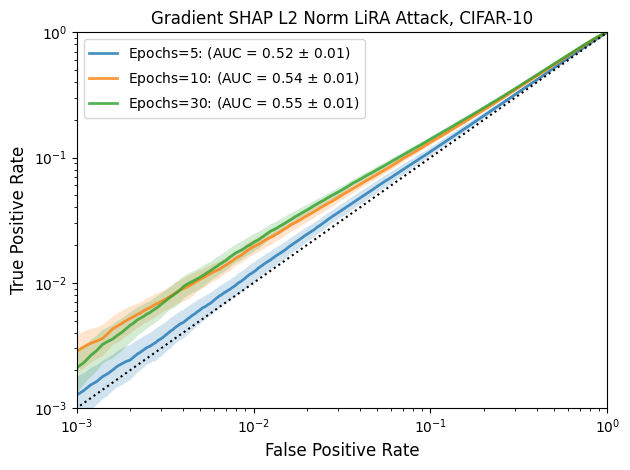

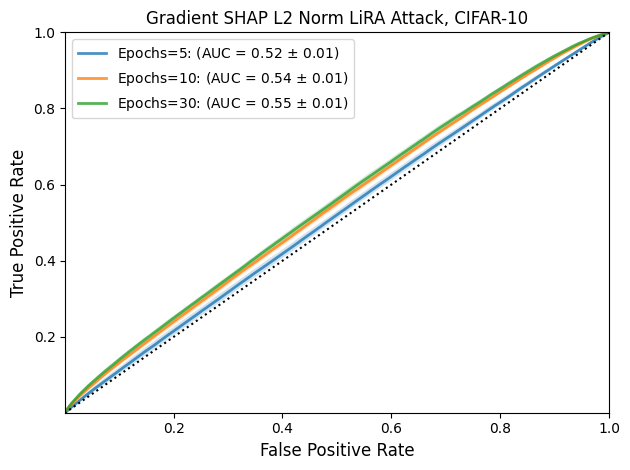

In [15]:
global_num_experiments = 33
results_nondp = {
'nonDP': {
    '5': {'tprs': [], 'aucs': []},
    '10': {'tprs': [], 'aucs': []},
    '30': {'tprs': [], 'aucs': []},
    }
}

epochs = [5, 10, 30]
mean_fpr = np.linspace(0, 1, 10000)

args = {
    'clipping_mode': 'nonDP',
    'cifar_data': 'CIFAR10',
    'model': 'vit_small_patch16_224', # 'vit_small_patch16_224', 
    'total_data_examples': 20000,
    'num_experiments': global_num_experiments,
    'explanation_type': global_exp_type,
    'nsamples': 20,
    'attack_type': global_attacktype_dir
}

for epoch_count in epochs:
    tpr_001_dir = f'lira/tpr001_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
    tpr_01_dir = f'lira/tpr01_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
    auc_dir = f'lira/auc_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
    if not os.path.exists(tpr_001_dir):
        os.makedirs(tpr_001_dir)
        print(f"Created directory: {tpr_001_dir}")
    if not os.path.exists(tpr_01_dir):
        os.makedirs(tpr_01_dir)
        print(f"Created directory: {tpr_01_dir}")
    if not os.path.exists(auc_dir):
        os.makedirs(auc_dir)
        print(f"Created directory: {auc_dir}")
    tpr_001_file_path = f'{tpr_001_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
    tpr_01_file_path = f'{tpr_01_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
    auc_file_path = f'{auc_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
    with open(tpr_001_file_path, 'w') as file:
        pass
    with open(tpr_01_file_path, 'w') as file:
        pass
    with open(auc_file_path, 'w') as file:
        pass
        
 # can eventually iterate only 10 times
for i, epoch_count in enumerate(epochs):
    args['epochs'] = epoch_count

    valid_experiment_list = []
    for attack_model_index in range(args['num_experiments']):
        if 'nonDP' not in args['clipping_mode']:
            lira_dir = f"lira/{args['attack_type']}_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_eps={args['epsilon']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
        else:
            lira_dir = f"lira/{args['attack_type']}_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
        if os.path.exists(f"{lira_dir}/{attack_model_index}.csv"):
            valid_experiment_list.append(attack_model_index)
                
    for attack_model_index, _ in tqdm(enumerate(valid_experiment_list)):
            
        tpr_001_dir = f'lira/tpr001_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
        tpr_01_dir = f'lira/tpr01_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
        tpr_001_file_path = f'{tpr_001_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
        tpr_01_file_path = f'{tpr_01_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
        auc_dir = f'lira/auc_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
        auc_file_path = f'{auc_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
        
        indices, scores = get_data(args, valid_experiment_list)
#         print(f'successfully got data: {attack_model_index}, {epoch_count}')
#         print(np.shape(scores))

        in_scores, out_scores, t0, mask_t0 = split_scores(scores, indices, min_keep=3, attack_model_index=attack_model_index)
#         if epoch_count == 30 and i == 0:
#             fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#             fig.suptitle('Distributions of Train vs. Test Explanation Variances, CIFAR-10, 30 Epochs, One Target Model', fontsize=12)

#             ax1.hist(in_scores, alpha=0.7, label='Train Variances', bins=np.linspace(0.0, 0.03, 24))
#             ax1.hist(out_scores, alpha=0.7, label='Test Variances', bins=np.linspace(0.0, 0.03, 24))
#             ax1.legend()
        
#             ax2.hist(np.log(in_scores), alpha=0.7, label='log(Train Variances)', bins=np.linspace(-16, -4, 26))
#             ax2.hist(np.log(out_scores), alpha=0.7, label='log(Test Variances)', bins=np.linspace(-16, -4, 26))
#             ax2.legend()
        in_scores, out_scores = get_lrt_scores(t0, mask_t0, in_scores, out_scores, global_var=True)

        num_rows = int(np.ceil(args['num_experiments'] / 4))
        num_cols = 4

        fpr, tpr, auc, acc = compute_curve(in_scores, out_scores)
        tpr = np.interp(mean_fpr, fpr, tpr)
        tpr[0] = 0.0
        low_001 = tpr[np.where(fpr<=.001)[0][-1]]
        low_01 = tpr[np.where(fpr<=.01)[0][-1]]
        with open(tpr_001_file_path, 'a') as file:
            file.write(str(low_001) + '\n')
        with open(tpr_01_file_path, 'a') as file:
            file.write(str(low_01) + '\n')
        with open(auc_file_path, 'a') as file:
            file.write(str(auc) + '\n')
        results_nondp['nonDP'][str(epoch_count)]['tprs'].append(tpr)
        results_nondp['nonDP'][str(epoch_count)]['aucs'].append(auc)   

plt.figure()
for i, epoch_count in enumerate(epochs):
    tprs = np.array(results_nondp['nonDP'][f'{epoch_count}']['tprs']).T
    aucs = np.array(results_nondp['nonDP'][f'{epoch_count}']['aucs']).T
    mean_tpr = np.mean(tprs, axis=1)
    std_tpr = np.std(tprs, axis=1)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs).round(2)
    std_auc = np.std(aucs).round(2)
    
    plt.loglog(mean_fpr, mean_tpr, label=f"Epochs={epoch_count}: (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2) #label=r"$\pm$ 1 std. dev.")

if args['explanation_type'] == 'ixg':
    nondp_title = f'Input X Gradient {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'sl':
    nondp_title = f'Saliency {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'dl':
    nondp_title = f'DeepLift {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'gs':
    nondp_title = f'Gradient SHAP {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'ig':
    nondp_title = f'Integrated Gradients {global_attacktype} LiRA Attack, CIFAR-10'
plt.plot([0,1], [0,1], linestyle='dotted', color='black')
plt.legend(loc=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlim([0.001, 1])
plt.ylim([0.001, 1])
plt.title(nondp_title)
plt.tight_layout()
if global_savefig:
    plt.savefig(f'plots/{nondp_title}.png')
plt.show()


#### plotting non-Log scaled curves ####
plt.figure()
for i, epoch_count in enumerate(epochs):
    tprs = np.array(results_nondp['nonDP'][f'{epoch_count}']['tprs']).T
    aucs = np.array(results_nondp['nonDP'][f'{epoch_count}']['aucs']).T
    mean_tpr = np.mean(tprs, axis=1)
    std_tpr = np.std(tprs, axis=1)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs).round(2)
    std_auc = np.std(aucs).round(2)
    
    plt.plot(mean_fpr, mean_tpr, label=f"Epochs={epoch_count}: (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2) #label=r"$\pm$ 1 std. dev.")
    

if args['explanation_type'] == 'ixg':
    nondp_title = f'Input X Gradient {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'sl':
    nondp_title = f'Saliency {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'dl':
    nondp_title = f'DeepLift {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'gs':
    nondp_title = f'Gradient SHAP {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'ig':
    nondp_title = f'Integrated Gradients {global_attacktype} LiRA Attack, CIFAR-10'
plt.plot([0,1], [0,1], linestyle='dotted', color='black')
plt.legend(loc=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlim([0.001, 1])
plt.ylim([0.001, 1])
plt.title(nondp_title)
plt.tight_layout()
if global_savefig:
    plt.savefig(f'plots/{nondp_title}, not log.png')
plt.show()

### changing number of shadow models

33


0it [00:00, ?it/s]

65


0it [00:00, ?it/s]

129


0it [00:00, ?it/s]

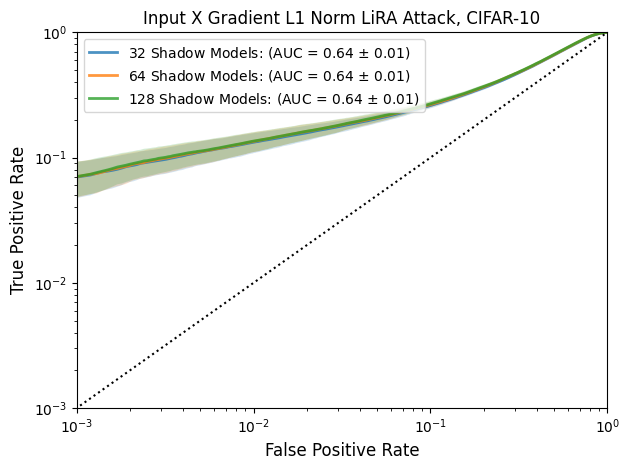

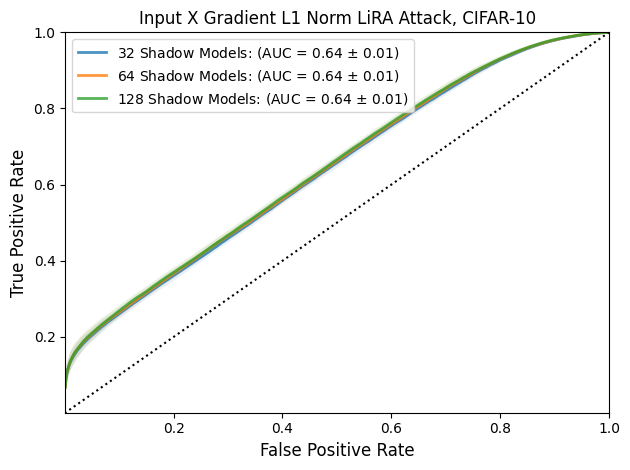

In [13]:
# global_num_experiments = 33
results_nondp = {
'nonDP': {
    '17': {'tprs': [], 'aucs': []},
    '33': {'tprs': [], 'aucs': []},
    '65': {'tprs': [], 'aucs': []},
    '129': {'tprs': [], 'aucs': []},
    }
}

epochs = [5, 10, 30]
epoch_count = 30
nums_experiments = [33,65, 129]
mean_fpr = np.linspace(0, 1, 10000)

args = {
    'clipping_mode': 'nonDP',
    'cifar_data': 'CIFAR10',
    'model': 'vit_small_patch16_224', # 'vit_small_patch16_224', 
    'total_data_examples': 20000,
#     'num_experiments': global_num_experiments,
    'explanation_type': global_exp_type,
    'nsamples': 20,
    'attack_type': global_attacktype_dir
}

for epoch_count in epochs:
    tpr_001_dir = f'lira/tpr001_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
    tpr_01_dir = f'lira/tpr01_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
    auc_dir = f'lira/auc_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
    if not os.path.exists(tpr_001_dir):
        os.makedirs(tpr_001_dir)
        print(f"Created directory: {tpr_001_dir}")
    if not os.path.exists(tpr_01_dir):
        os.makedirs(tpr_01_dir)
        print(f"Created directory: {tpr_01_dir}")
    if not os.path.exists(auc_dir):
        os.makedirs(auc_dir)
        print(f"Created directory: {auc_dir}")
    tpr_001_file_path = f'{tpr_001_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
    tpr_01_file_path = f'{tpr_01_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
    auc_file_path = f'{auc_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
    with open(tpr_001_file_path, 'w') as file:
        pass
    with open(tpr_01_file_path, 'w') as file:
        pass
    with open(auc_file_path, 'w') as file:
        pass
        
 # can eventually iterate only 10 times
for i, num_experiments in enumerate(nums_experiments):
    print(num_experiments)
    args['epochs'] = epoch_count
    args['num_experiments'] = num_experiments

    valid_experiment_list = []
    for attack_model_index in range(args['num_experiments']):
        if 'nonDP' not in args['clipping_mode']:
            lira_dir = f"lira/{args['attack_type']}_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_eps={args['epsilon']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
        else:
            lira_dir = f"lira/{args['attack_type']}_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
        if os.path.exists(f"{lira_dir}/{attack_model_index}.csv"):
            valid_experiment_list.append(attack_model_index)
                
    for attack_model_index, _ in tqdm(enumerate(valid_experiment_list[:15])):
            
        tpr_001_dir = f'lira/tpr001_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
        tpr_01_dir = f'lira/tpr01_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
        tpr_001_file_path = f'{tpr_001_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
        tpr_01_file_path = f'{tpr_01_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
        auc_dir = f'lira/auc_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
        auc_file_path = f'{auc_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
        
        indices, scores = get_data(args, valid_experiment_list)
#         print(f'successfully got data: {attack_model_index}, {epoch_count}')
#         print(np.shape(scores))

        in_scores, out_scores, t0, mask_t0 = split_scores(scores, indices, min_keep=3, attack_model_index=attack_model_index)
#         if epoch_count == 30 and i == 0:
#             fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#             fig.suptitle('Distributions of Train vs. Test Explanation Variances, CIFAR-10, 30 Epochs, One Target Model', fontsize=12)

#             ax1.hist(in_scores, alpha=0.7, label='Train Variances', bins=np.linspace(0.0, 0.03, 24))
#             ax1.hist(out_scores, alpha=0.7, label='Test Variances', bins=np.linspace(0.0, 0.03, 24))
#             ax1.legend()
        
#             ax2.hist(np.log(in_scores), alpha=0.7, label='log(Train Variances)', bins=np.linspace(-16, -4, 26))
#             ax2.hist(np.log(out_scores), alpha=0.7, label='log(Test Variances)', bins=np.linspace(-16, -4, 26))
#             ax2.legend()
        in_scores, out_scores = get_lrt_scores(t0, mask_t0, in_scores, out_scores, global_var=True)

        num_rows = int(np.ceil(args['num_experiments'] / 4))
        num_cols = 4

        fpr, tpr, auc, acc = compute_curve(in_scores, out_scores)
        tpr = np.interp(mean_fpr, fpr, tpr)
        tpr[0] = 0.0
        low_001 = tpr[np.where(fpr<=.001)[0][-1]]
        low_01 = tpr[np.where(fpr<=.01)[0][-1]]
        with open(tpr_001_file_path, 'a') as file:
            file.write(str(low_001) + '\n')
        with open(tpr_01_file_path, 'a') as file:
            file.write(str(low_01) + '\n')
        with open(auc_file_path, 'a') as file:
            file.write(str(auc) + '\n')
        results_nondp['nonDP'][str(num_experiments)]['tprs'].append(tpr)
        results_nondp['nonDP'][str(num_experiments)]['aucs'].append(auc)   

plt.figure()
for i, num_experiments in enumerate(nums_experiments):
    tprs = np.array(results_nondp['nonDP'][f'{num_experiments}']['tprs']).T
    aucs = np.array(results_nondp['nonDP'][f'{num_experiments}']['aucs']).T
    mean_tpr = np.mean(tprs, axis=1)
    std_tpr = np.std(tprs, axis=1)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs).round(2)
    std_auc = np.std(aucs).round(2)
    
    plt.loglog(mean_fpr, mean_tpr, label=f"{num_experiments - 1} Shadow Models: (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2) #label=r"$\pm$ 1 std. dev.")

if args['explanation_type'] == 'ixg':
    nondp_title = f'Input X Gradient {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'sl':
    nondp_title = f'Saliency {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'dl':
    nondp_title = f'DeepLift {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'gs':
    nondp_title = f'Gradient SHAP {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'ig':
    nondp_title = f'Integrated Gradients {global_attacktype} LiRA Attack, CIFAR-10'
plt.plot([0,1], [0,1], linestyle='dotted', color='black')
plt.legend(loc=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlim([0.001, 1])
plt.ylim([0.001, 1])
plt.title(nondp_title)
plt.tight_layout()
# if global_savefig:
#     plt.savefig(f'plots/{nondp_title}.png')
plt.show()


#### plotting non-Log scaled curves ####
plt.figure()
for i, num_experiments in enumerate(nums_experiments):
    tprs = np.array(results_nondp['nonDP'][f'{num_experiments}']['tprs']).T
    aucs = np.array(results_nondp['nonDP'][f'{num_experiments}']['aucs']).T
    mean_tpr = np.mean(tprs, axis=1)
    std_tpr = np.std(tprs, axis=1)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs).round(2)
    std_auc = np.std(aucs).round(2)
    
    plt.plot(mean_fpr, mean_tpr, label=f"{num_experiments - 1} Shadow Models: (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.1) #label=r"$\pm$ 1 std. dev.")
    

if args['explanation_type'] == 'ixg':
    nondp_title = f'Input X Gradient {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'sl':
    nondp_title = f'Saliency {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'dl':
    nondp_title = f'DeepLift {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'gs':
    nondp_title = f'Gradient SHAP {global_attacktype} LiRA Attack, CIFAR-10'
elif args['explanation_type'] == 'ig':
    nondp_title = f'Integrated Gradients {global_attacktype} LiRA Attack, CIFAR-10'
plt.plot([0,1], [0,1], linestyle='dotted', color='black')
plt.legend(loc=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlim([0.001, 1])
plt.ylim([0.001, 1])
plt.title(nondp_title)
plt.tight_layout()
# if global_savefig:
#     plt.savefig(f'plots/{nondp_title}, not log.png')
plt.show()

In [18]:
results_nondp

{'nonDP': {'33': {'tprs': [array([0.    , 0.0489, 0.055 , ..., 0.9999, 0.9999, 1.    ]),
    array([0.    , 0.0599, 0.0608, ..., 1.    , 1.    , 1.    ]),
    array([0.    , 0.0526, 0.0585, ..., 1.    , 1.    , 1.    ]),
    array([0.    , 0.0023, 0.0027, ..., 0.9999, 1.    , 1.    ]),
    array([0.    , 0.0333, 0.0478, ..., 1.    , 1.    , 1.    ]),
    array([0.    , 0.0541, 0.0547, ..., 1.    , 1.    , 1.    ]),
    array([0.    , 0.0277, 0.0497, ..., 0.9999, 0.9999, 1.    ]),
    array([0.    , 0.0441, 0.0531, ..., 1.    , 1.    , 1.    ]),
    array([0.    , 0.0392, 0.0429, ..., 1.    , 1.    , 1.    ]),
    array([0.    , 0.0462, 0.0472, ..., 1.    , 1.    , 1.    ]),
    array([0.    , 0.0533, 0.0606, ..., 1.    , 1.    , 1.    ]),
    array([0.    , 0.0485, 0.0554, ..., 1.    , 1.    , 1.    ]),
    array([0.    , 0.0097, 0.0118, ..., 1.    , 1.    , 1.    ]),
    array([0.    , 0.0103, 0.0149, ..., 0.9999, 0.9999, 1.    ]),
    array([0.    , 0.051 , 0.0596, ..., 1.    , 1.   

## simple loss thresholding

In [33]:
from sklearn import metrics
def compute_curve(train_scores: list, test_scores: list, pos_label=1):
    '''
    Compute ROC curve for subsequent plotting and AUC score calculation.
    Args:
        train_scores: distance quantities used for MI attacks associated with training data (CFD, or CFD LRT)
        test_scores: distance quantities used for MI attacks associated with test (non-training) data (CFD, or CFD LRT)
        train_preds: predicted labels on training data
        test_preds: predicted labels on test data
    Returns: tprs and fprs, and balanced accuracy
    '''
    # y: true 0/1 labels
    # because train_scores (label: 1) are called in this function before test_scores (label: 0)
    y = np.r_[np.ones(np.shape(train_scores)[0]), np.zeros(np.shape(test_scores)[0])]
    # np.r_[train_scores, test_scores]: distance quantities used for MI attacks
    # either counterfactual distance or CFD LRT
    # metrics.roc_curve itself handles thresholding
    fpr, tpr, thresholds = metrics.roc_curve(y, -np.r_[train_scores, test_scores], pos_label=pos_label)

    acc = np.max(1-(fpr+(1-tpr))/2)
#     print(acc)
    
    return fpr, tpr, metrics.auc(fpr, tpr), acc

In [34]:
results_simple = {
'nonDP': {'5': {'tprs': [], 'aucs': [], 'accs': []},
          '10': {'tprs': [], 'aucs': [], 'accs': []},
          '30': {'tprs': [], 'aucs': [], 'accs': []},
    }
}

epochs = [5, 10, 30]
mean_fpr = np.linspace(0, 1, 10000)

args = {
    'clipping_mode': 'nonDP',
    'cifar_data': 'CIFAR10',
    'model': 'vit_small_patch16_224', # 'vit_small_patch16_224', 
    'total_data_examples': 20000,
    'num_experiments': global_num_experiments,
    'explanation_type': global_exp_type,
    'nsamples': 20,
    'attack_type': global_attacktype_dir
}

for epoch_count in epochs:
    tpr_001_dir = f'lira/tpr001simple_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
    tpr_01_dir = f'lira/tpr01simple_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
    auc_dir = f'lira/aucsimple_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
    if not os.path.exists(tpr_001_dir):
        os.makedirs(tpr_001_dir)
        print(f"Created directory: {tpr_001_dir}")
    if not os.path.exists(tpr_01_dir):
        os.makedirs(tpr_01_dir)
        print(f"Created directory: {tpr_01_dir}")
    if not os.path.exists(auc_dir):
        os.makedirs(auc_dir)
        print(f"Created directory: {auc_dir}")
    tpr_001_file_path = f'{tpr_001_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
    tpr_01_file_path = f'{tpr_01_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
    auc_file_path = f'{auc_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
    with open(tpr_001_file_path, 'w') as file:
        pass
    with open(tpr_01_file_path, 'w') as file:
        pass
    with open(auc_file_path, 'w') as file:
        pass
    
for i, epoch_count in enumerate(epochs):
    args['epochs'] = epoch_count

    valid_experiment_list = []
    for attack_model_index in range(args['num_experiments']):
        if 'nonDP' not in args['clipping_mode']:
            lira_dir = f"lira/{args['attack_type']}_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_eps={args['epsilon']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
        else:
            lira_dir = f"lira/{args['attack_type']}_{args['cifar_data']}_{args['total_data_examples']}/model={args['model']}_mode={args['clipping_mode']}_type={args['explanation_type']}_nsamples={args['nsamples']}_epochs={args['epochs']}"
        if os.path.exists(f"{lira_dir}/{attack_model_index}.csv"):
            valid_experiment_list.append(attack_model_index)

    for attack_model_index, _ in tqdm(enumerate(valid_experiment_list)): # can eventually iterate only 10 times
        
        tpr_001_dir = f'lira/tpr001simple_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
        tpr_01_dir = f'lira/tpr01simple_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
        tpr_001_file_path = f'{tpr_001_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={args["epochs"]}.txt'
        tpr_01_file_path = f'{tpr_01_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={args["epochs"]}.txt'
        auc_dir = f'lira/aucsimple_{args["cifar_data"]}_{args["total_data_examples"]}_{global_attacktype}'
        auc_file_path = f'{auc_dir}/model={args["model"]}_mode={args["clipping_mode"]}_type={args["explanation_type"]}_epochs={epoch_count}.txt'
        
        indices, scores = get_data(args, valid_experiment_list)
        indices_for_attack = indices[:, attack_model_index]
        ones = np.where(indices_for_attack == 1)[0]
        zeros = np.where(indices_for_attack == 0)[0]

        scores_for_attack = scores[:, attack_model_index]
        one_scores = scores_for_attack[ones]
        zero_scores = scores_for_attack[zeros]

        fpr, tpr, auc, acc = compute_curve(one_scores, zero_scores)
    
        tpr = np.interp(mean_fpr, fpr, tpr)
        tpr[0] = 0.0
        low_001 = tpr[np.where(fpr<=.001)[0][-1]]
        low_01 = tpr[np.where(fpr<=.01)[0][-1]]
        with open(tpr_001_file_path, 'a') as file:
            file.write(str(low_001) + '\n')
        with open(tpr_01_file_path, 'a') as file:
            file.write(str(low_01) + '\n')
        with open(auc_file_path, 'a') as file:
            file.write(str(auc) + '\n')
        results_simple['nonDP'][str(epoch_count)]['tprs'].append(tpr)
        results_simple['nonDP'][str(epoch_count)]['aucs'].append(auc)   
        results_simple['nonDP'][str(epoch_count)]['accs'].append(acc)   

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

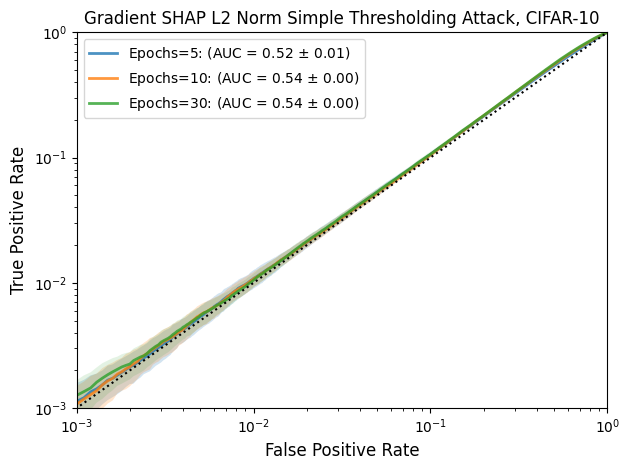

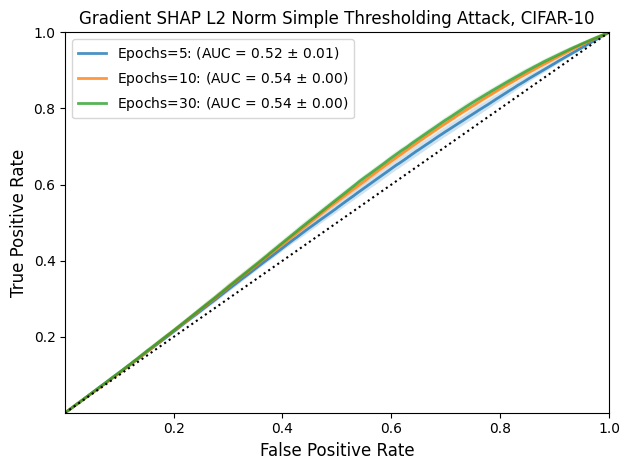

In [35]:
###### log scaled curves #####
plt.figure()
for i, epoch_count in enumerate(epochs):
    tprs = np.array(results_simple['nonDP'][f'{epoch_count}']['tprs']).T
    aucs = np.array(results_simple['nonDP'][f'{epoch_count}']['aucs']).T
    accs = np.array(results_simple['nonDP'][f'{epoch_count}']['accs']).T
    mean_tpr = np.mean(tprs, axis=1)
    std_tpr = np.std(tprs, axis=1)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs).round(2)
    std_auc = np.std(aucs).round(2)
    
    mean_acc = np.mean(accs).round(2)
    std_acc = np.std(accs).round(2)
    
    plt.loglog(mean_fpr, mean_tpr, label=f"Epochs={epoch_count}: (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    if epoch_count >= 30:
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.13) #label=r"$\pm$ 1 std. dev.")
    else:
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2)
    
if args['explanation_type'] == 'ixg':
    nondp_simple_title = f'Input X Gradient {global_attacktype} Simple Thresholding Attack, CIFAR-10'
elif args['explanation_type'] == 'sl':
    nondp_simple_title = f'Saliency {global_attacktype} Simple Thresholding Attack, CIFAR-10'
elif args['explanation_type'] == 'dl':
    nondp_simple_title = f'DeepLift {global_attacktype} Simple Thresholding Attack, CIFAR-10'
elif args['explanation_type'] == 'gs':
    nondp_simple_title = f'Gradient SHAP {global_attacktype} Simple Thresholding Attack, CIFAR-10'
elif args['explanation_type'] == 'ig':
    nondp_simple_title = f'Integrated Gradients {global_attacktype} Simple Thresholding Attack, CIFAR-10'
plt.plot([0,1], [0,1], linestyle='dotted', color='black')
plt.legend(loc=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlim([0.001, 1])
plt.ylim([0.001, 1])
plt.title(nondp_simple_title)
plt.tight_layout()
if global_savefig:
    plt.savefig(f'plots/{nondp_simple_title}.png')
plt.show()

#### non Log scaled curves #####
plt.figure()
for i, epoch_count in enumerate(epochs):
    tprs = np.array(results_simple['nonDP'][f'{epoch_count}']['tprs']).T
    aucs = np.array(results_simple['nonDP'][f'{epoch_count}']['aucs']).T
    accs = np.array(results_simple['nonDP'][f'{epoch_count}']['accs']).T
    mean_tpr = np.mean(tprs, axis=1)
    std_tpr = np.std(tprs, axis=1)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs).round(2)
    std_auc = np.std(aucs).round(2)
    
    mean_acc = np.mean(accs).round(2)
    std_acc = np.std(accs).round(2)
    
    plt.plot(mean_fpr, mean_tpr, label=f"Epochs={epoch_count}: (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    if epoch_count >= 30:
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.13) #label=r"$\pm$ 1 std. dev.")
    else:
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2)
   
if args['explanation_type'] == 'ixg':
    nondp_simple_title = f'Input X Gradient {global_attacktype} Simple Thresholding Attack, CIFAR-10'
elif args['explanation_type'] == 'sl':
    nondp_simple_title = f'Saliency {global_attacktype} Simple Thresholding Attack, CIFAR-10'
elif args['explanation_type'] == 'dl':
    nondp_simple_title = f'DeepLift {global_attacktype} Simple Thresholding Attack, CIFAR-10'
elif args['explanation_type'] == 'gs':
    nondp_simple_title = f'Gradient SHAP {global_attacktype} Simple Thresholding Attack, CIFAR-10'
elif args['explanation_type'] == 'ig':
    nondp_simple_title = f'Integrated Gradients {global_attacktype} Simple Thresholding Attack, CIFAR-10'
plt.plot([0,1], [0,1], linestyle='dotted', color='black')
plt.legend(loc=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlim([0.001, 1])
plt.ylim([0.001, 1])
plt.title(nondp_simple_title)
plt.tight_layout()
if global_savefig:
    plt.savefig(f'plots/{nondp_simple_title}, not log.png')
plt.show()

In [36]:
# for attack_model_index in range(args['num_experiments']):
#     indices_for_attack = indices[:, attack_model_index]
#     ones = np.where(indices_for_attack == 1)[0]
#     zeros = np.where(indices_for_attack == 0)[0]

#     # scores = np.array(torch.randn((args['total_data_examples'], args['num_experiments'])) * 0.01)
#     scores_for_attack = scores[:, attack_model_index]
#     one_scores = scores_for_attack[ones]
#     zero_scores = scores_for_attack[zeros]

#     fprs, tprs, auc, acc = compute_curve(one_scores, zero_scores)

#     auc = np.round_(metrics.auc(fprs, tprs), 4)
    
#     fig = plt.figure(figsize=(7, 3)) 
    
#     plt.subplot(1, 2, 1)
#     plt.loglog(fprs, tprs, label=f"AUC: {auc}, ACC: {acc}")
#     plt.plot([0,1], [0,1], label='Random Baseline', linestyle='dotted', color='black')
#     plt.xlabel("log(False Positive Rate)")
#     plt.ylabel("log(True Positive Rate)")
#     plt.xlim([0.001, 1.01])
#     plt.ylim([0.001, 1.01])
    
#     plt.subplot(1, 2, 2)
#     plt.plot(fprs, tprs, label=f"AUC: {auc}, ACC: {acc}")
#     plt.plot([0,1], [0,1], label='Random Baseline', linestyle='dotted', color='black')
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.xlim([0.001, 1.01])
#     plt.ylim([0.001, 1.01])
#     if args['explanation_type'] == 'ig':
#         plt.title(f"Integrated Gradients Simple MI Attack, Baseline Model")
#     elif args['explanation_type'] == 'gs':
#         plt.title(f"Gradient SHAP Simple MI Attack, Baseline Model")
#     plt.legend()
#     # if args['save_fig']:
#     #     if args['dp_model']:
#     #         save_dir = f'results_dpmodel/{args["explanation_type"]}'
#     #     else:
#     #         save_dir = f'results/{args["explanation_type"]}'
#     #     plt.savefig(f'{save_dir}/simple_mi_roc.png')
#     plt.show()